In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.regularizers import l2
from keras.layers import (
    Input, Conv2D, Conv2DTranspose, BatchNormalization, 
    Dropout, AveragePooling2D, MaxPooling2D, Concatenate, Activation
)

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
allow_growth_session = tf.Session(config=config)
tf.keras.backend.set_session(allow_growth_session)

Using TensorFlow backend.


In [25]:
import os
import glob
import random
import numpy as np
import skimage.io as io
from utils import utils, helpers

def imread(fname, size=(400, 640)):
    im = cv2.imread(fname)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, size, interpolation=cv2.INTER_AREA)
    return im

class DataGenerator(keras.utils.Sequence):
    # https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    'Generates data for Keras'
    def __init__(
        self, folder, set_folder='train', batch_size=32, dim=(640,400), n_channels=3, n_classes=4, shuffle=True,
        augmentation={'h_flip': False, 'v_flip': False, 'brightness': None, 'rotation': None}
    ):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.folder = folder
        self.images = self.get_files(set_folder)
        self.labels = self.get_files(set_folder+'_labels')
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # im_indexes = self.images[indexes*self.batch_size:(index+1)*self.batch_size]
        # lb_indexes = self.labels[indexes*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.__len__())
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def get_files(self, type_folder):
        return sorted(glob.glob(os.path.join(self.folder, type_folder, '*')))
    
    def dataAugmentation(self, input_image, output_image):
        if self.augmentation['h_flip'] and random.randint(0,1):
            input_image = cv2.flip(input_image, 1)
            output_image = cv2.flip(output_image, 1)
        if self.augmentation['v_flip'] and random.randint(0,1):
            input_image = cv2.flip(input_image, 0)
            output_image = cv2.flip(output_image, 0)
        if self.augmentation['brightness']:
            factor = 1.0 + random.uniform(-1.0*self.augmentation['brightness'], self.augmentation['brightness'])
            table = np.array([((i / 255.0) * factor) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
            input_image = cv2.LUT(input_image, table)
        if self.augmentation['rotation']:
            angle = random.uniform(-1*self.augmentation['rotation'], self.augmentation['rotation'])
        if self.augmentation['rotation']:
            M = cv2.getRotationMatrix2D((input_image.shape[1]//2, input_image.shape[0]//2), angle, 1.0)
            input_image = cv2.warpAffine(input_image, M, (input_image.shape[1], input_image.shape[0]), flags=cv2.INTER_NEAREST)
            output_image = cv2.warpAffine(output_image, M, (output_image.shape[1], output_image.shape[0]), flags=cv2.INTER_NEAREST)

        return input_image, output_image
    
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), np.uint8)
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=np.uint8)
        # dividir y con to one hot de utils

        # Generate data
        for i, idx in enumerate(indexes):
            # Store sample
            # X[i,] = utils.load_image(self.images[idx])
            # lb = np.load(self.labels[idx])
            # for x in np.unique(lb):
            #     y[i,...,x] = np.where(lb == x, 1, 0)
            
            # load data
            im = utils.load_image(self.images[idx])
            lb = np.load(self.labels[idx])
            im, lb = self.dataAugmentation(im, lb)
            
            # assign data to batch
            X[i, ] = im
            for x in np.unique(lb):
                y[i, ..., x] = np.where(lb == x, 1, 0)

        return X, y

In [34]:
augmentation = {'h_flip': True, 'v_flip': True, 'brightness': .25, 'rotation': 25}

trainG = DataGenerator('openeds_split', 'train', 1, augmentation=augmentation)
testG = DataGenerator('openeds_split', 'test', 1)
valG = DataGenerator('openeds_split', 'val', 1)

print(len(trainG) + len(testG) + len(valG))

11319


In [35]:
tt = zip(trainG.images, trainG.labels)

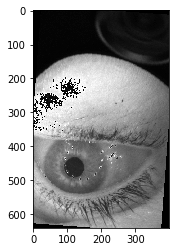

In [36]:
trainG.on_epoch_end()
im, lb = trainG[0]
plt.imshow(im[0])

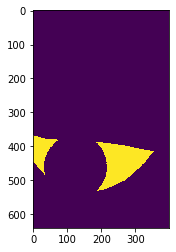

In [37]:
plt.imshow(lb[0][..., 1])